<a href="https://colab.research.google.com/github/tayalkshitij/LLaMA2/blob/main/LLaMA_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# MIT License
#
#@title Copyright (c) Authors { display-mode: "form" }
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

<body>
    <h1>Tutorial: Building LLaMA 2 in Pytorch</h1>
    <p>Author(s):</p>
    <ul>
        <li>Kshitij Tayal, Oak Ridge National Labs, <a href="mailto:tayalk@ornl.gov">tayalk@ornl.gov</a></li>
        <li>Arvind Renganathan, Oak Ridge National Labs, <a href="mailto:renga016@umn.edu">renganathana@ornl.gov</a></li>
        <li>Arun Sharma, University of Minnesota, <a href="mailto:sharm485@umn.edu">sharm485@umn.edu</a></li>
        <li>Dan Lu, Oak Ridge National Labs, <a href="mailto:lud1@ornl.gov">lud1@ornl.gov</a></li>
    </ul>
    <p> This comprehensive tutorial will guide you through coding the open-source and widely popular LLaMA 2 language model from scratch using PyTorch. By breaking down the implementation of key architectural components and inference methods, we aim to provide you with a deep understanding of the inner workings of state-of-the-art language models. Throughout the tutorial, you will gain hands-on experience in building the LLaMA 2 model while exploring its components' mathematical foundations. We will cover essential concepts and techniques, such as attention mechanisms, transformers, and tokenization, empowering you to grasp the complexities of language modeling. By the end of this tutorial, you will have a solid grasp of the LLaMA 2 architecture and can harness the power of generative AI and apply it to your specific use cases, whether in natural language processing, text generation, or other related fields.</p>
</body>



# Table of Contents


*   [Overview](#overview)
*   [Background & Prerequisites](#background-and-prereqs)
*   [Software Requirements](#software-requirements)
*   [Model Download](#data-description)
*   [Model Architecture](#methodology)
*   [Scaling Law](#scalinglaw)
*   [Prompts](#prompts)
*   [Limitation](#limitation)
*   [References](#references)


<a name="overview"></a>





# Overview

<center>
  <img src="https://raw.githubusercontent.com/tayalkshitij/LLaMA2/main/images/llama2_architecture.png" width="700">
  <div>Image source: <a href="https://llama.meta.com/llama2/"> Meta </a></div>
</center>


<p>
        The figure illustrates the <strong>LLaMa 2</strong>, architecture. Below is the brief description of the components and processes depicted in the image:
</p>



## 1. Input Processing
- The model starts with embeddings of the input tokens.
- These embeddings are then passed through an RMS Normalization layer.

## 2. Main Processing Block (Nx)
This block is repeated N times, forming the core of the model:
- Uses Rotary Positional Encodings for Q, K, and V
- Implements Grouped Multi-Query Attention for efficiency
- Utilizes a KV Cache to speed up sequential processing

## 3. Feed Forward Network
Uses SwiGLU activation function, an variant of GLU (Gated Linear Unit).

## 4. After N repetitions of the main block:
- RMS Normalization
- Linear Layer: Projects to the vocabulary size
- Softmax: Produces final token probabilities

## Key Distinct Features
- RMS Norm: Used instead of Layer Norm for faster computation
- Rotary Positional Encodings: Allows the model to better understand token positions
- Grouped Multi-Query Attention: Improves efficiency in the attention mechanism
- SwiGLU Activation: Enhances the model's ability to capture complex patterns

This architecture is designed to balance performance and efficiency, allowing the model to achieve strong results while being more computationally efficient than some other large language models.















<a name="background-and-prereqs"></a>
# Background & Prerequisites

This tutorial is designed for individuals with a basic programming experience in Python, Pytorch which will be helpful for understanding the code examples and implementations discussed. Although not strictly necessary, some familiarity with concepts in linear algebra, such as matrix multiplication and dot products, is beneficial. Knowledge of complex numbers and Euler's formula is a nice-to-have but not essential for grasping the core concepts. No prior expertise in machine learning is required as we will start with introductory concepts of the Transformer model, including its structure and the attention mechanism, offering step-by-step guidance through the Transformer architecture and its functionalities.

## Videos
For users looking to delve deeper, these videos offer detailed explanations and insights into the functioning and implementation of the LLaMa architecture.

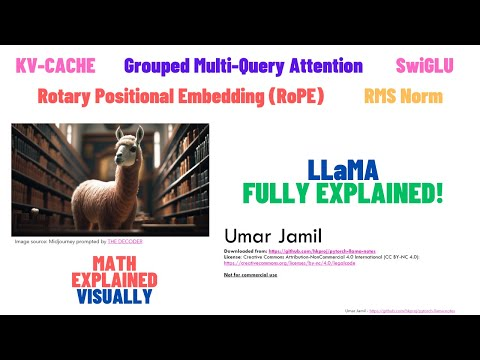

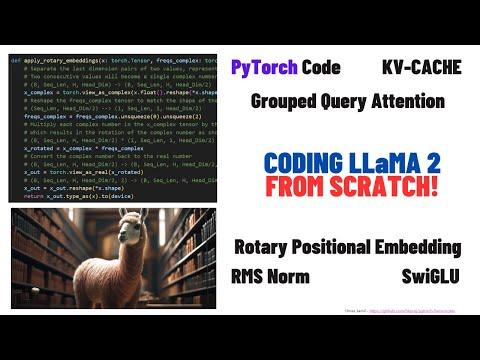

In [ ]:
from IPython.display import YouTubeVideo, display

# Display the first video
display(YouTubeVideo('Mn_9W1nCFLo'))

# Display the second video
display(YouTubeVideo('oM4VmoabDAI'))

## References

These resources illustrate the applications of the LLaMA 2 foundational model, developed by Meta AI, highlighting its capabilities in natural language processing tasks, and comparing it with other machine learning models.


1. Touvron, H., Lavril, T., Izacard, G., Martinet, X., Lachaux, M. A., Lacroix, T., ... & Lample, G. (2023). Llama 2: Open foundation and fine-tuned chat models. arXiv preprint arXiv:2307.09288. [Link to the article](https://arxiv.org/abs/2307.09288)


<a name="software-requirements"></a>
# Software Requirements


In [ ]:
# Standard library imports
import glob
import os
import time
import json
from pathlib import Path
import shutil
import urllib.request
import zipfile

# Third-party library imports
import importlib
import matplotlib.pyplot as plt
import numpy as np
from numba import njit
import pandas as pd
import requests
import seaborn as sns
import torch
from torch import nn
import torch.nn.functional as F
from sentencepiece import SentencePieceProcessor
from dataclasses import dataclass
from torch.utils.data import DataLoader, Dataset
import tqdm
from typing import List, Dict, Tuple,Optional

<a name="data-description"></a>
# Model Download

1. Go to https://llama.meta.com/llama-downloads/

<center>
  <img src="https://raw.githubusercontent.com/tayalkshitij/LLaMA2/main/images/access_form.png" width="700">
</center>

2. Enter Personal Details:
  - **First Name & Last Name**: Enter your first and last names in the respective fields.
  - **Date of Birth**: Select your birth month, day, and year from the dropdown menus.

3. Contact Information:
  - **Email**: Provide your email address.
  - **Country / Region**: Choose your country or region from the dropdown menu.
  - **Organization / Affiliation**: Optionally, add the name of your organization or affiliation.

4. Select Models for Access:
  - [ ] Meta Llama 3
  - [x] Meta Llama 2
  - [ ] Meta Code Llama
  Select the checkboxes next to the models you wish to access.

5. Safety Features:
  - [x] Meta Llama Guard 2 (Recommended)
  Check the box to add safety features to your model.

6. Review and Submit:
  - Ensure all the information is correct and click the submit button to complete your access request.


  <center>
  <img src="https://raw.githubusercontent.com/tayalkshitij/LLaMA2/main/images/llama_key.png" width="700">
</center>

In [ ]:
def download_file(url, filename):
    r = requests.get(url, stream=True)
    with open(filename, 'wb') as f:
        for chunk in r.iter_content(chunk_size=1024):
            if chunk:
                f.write(chunk)
                f.flush()
    print(f"Downloaded {filename}")

def download_files(base_url):

    files = [
        ("src/download.sh", "download.sh"),
        ("src/model.py", "model.py"),
        ("src/inference.py", "inference.py")
    ]

    for file_path, filename in files:
        url = base_url + file_path
        download_file(url, filename)

    print("All files downloaded successfully.")

base_url = "https://raw.githubusercontent.com/tayalkshitij/LLaMA2/main/"

download_files(base_url)
!chmod +x /content/download.sh
!/content/download.sh

Downloaded download.sh
Downloaded model.py
Downloaded inference.py
All files downloaded successfully.
Enter the URL from email: ^C


In [ ]:
import inference
importlib.reload(inference)
from inference import LLaMA

allow_cuda = False
device = 'cuda' if torch.cuda.is_available() and allow_cuda else 'cpu'
device

model = LLaMA.build(
        checkpoints_dir='/content/llama-2-7b-chat/',
        tokenizer_path='tokenizer.model',
        load_model=True,
        max_seq_len=1024,
        max_batch_size=1,
        device=device
    )

Loading checkpoint "/content/llama-2-7b-chat/consolidated.00.pth"
Loaded checkpoint in 8.47s
Loaded state dict in 65.13s


In [ ]:
prompts = ["Here is a funny story about a dog and a human in english"]
out_tokens, out_texts = (model.text_completion(prompts, max_gen_len=128))
for i in range(len(out_texts)):
  print(f'{out_texts[i]}')
  print('-' * 50)

Generating tokens: 100%|██████████| 143/143 [00:40<00:00,  3.54it/s]

Here is a funny story about a dog and a human in english.
Once upon a time, there was a dog named Max. Max loved to play fetch with his owner, John. One day, John threw the ball really far and Max ran after it. But when Max came back, he didn't have the ball. He looked at John with a sad face and barked. John laughed and said, "Don't worry, Max. I'll get it for you." But when John went to get the ball, it was gone. Max barked again and John laughed even harder.
The next day, John threw the ball again and Max ran after it.
--------------------------------------------------


<a name="methodology"></a>
# Model Architecture
<center>
  <img src="https://raw.githubusercontent.com/tayalkshitij/LLaMA2/main/images/llama2_architecture.png" width="700">
  <div>Image source: <a href="https://llama.meta.com/llama2/"> Meta </a></div>
</center>

## EncoderBlock Class

### Parameters:
- `args`: An instance of `ModelArgs`, that contains configuration parameters.

### Components:
- **Number of Heads** (`self.n_heads`): Stores the number of attention heads.
- **Dimensionality** (`self.dim`): Total dimensionality of the model.
- **Head Dimension** (`self.head_dim`): Dimensionality of each attention head, calculated by dividing the total dimension by the number of heads.
- **Attention Block** (`self.attention`): An instance of `SelfAttention`, initialized with `args`.
- **Feed Forward Block** (`self.feed_forward`): An instance of `FeedForward`, initialized with `args`.
- **Attention Normalization** (`self.attention_norm`): Applies RMS normalization before the attention block, initialized with the dimension and a small epsilon value for numerical stability.
- **Feed Forward Normalization** (`self.ffn_norm`): Similar to `self.attention_norm`, but applies normalization before the feed-forward block.

### Forward Method Parameters:
  - `x`: The input tensor to the encoder block.
  - `start_pos`: Start position for the attention mechanism.
  - `freqs_complex`: A tensor representing frequency components, used in the attention calculations.

### Process:
  1. **Normalize and Apply Attention**:
    - First, `x` is normalized using `self.attention_norm`.
    - The normalized `x` is then passed to `self.attention` along with `start_pos` and `freqs_complex`.
    - The result is added to the original input tensor `x` to create `h`.
  2. **Normalize and Apply Feed Forward**:
    - `h` is normalized using `self.ffn_norm`.
    - The normalized `h` is passed to `self.feed_forward`.
    - The output of `self.feed_forward` is added to `h` to create the final output tensor `out`.

### Returns:
- `out`: The output tensor of the encoder block is passed to the next block in the network.


In [ ]:
@dataclass
class ModelArgs:
    dim: int = 4096
    n_layers: int = 32
    n_heads: int = 32
    n_kv_heads: Optional[int] = None
    vocab_size: int = -1 # Later set in the build method
    multiple_of: int = 256
    ffn_dim_multiplier: Optional[float] = None
    norm_eps: float = 1e-5

    # Needed for KV cache
    max_batch_size: int = 32
    max_seq_len: int = 2048

    device: str = None

class EncoderBlock(nn.Module):

    def __init__(self, args: ModelArgs):
        super().__init__()

        self.n_heads = args.n_heads
        self.dim = args.dim
        self.head_dim = args.dim // args.n_heads

        self.attention = SelfAttention(args)
        self.feed_forward = FeedForward(args)

        # Normalization BEFORE the attention block
        self.attention_norm = RMSNorm(args.dim, eps=args.norm_eps)
        # Normalization BEFORE the feed forward block
        self.ffn_norm = RMSNorm(args.dim, eps=args.norm_eps)

    def forward(self, x: torch.Tensor, start_pos: int, freqs_complex: torch.Tensor):
        # (B, Seq_Len, Dim) + (B, Seq_Len, Dim) --> (B, Seq_Len, Dim)
        h = x + self.attention.forward(
            self.attention_norm(x), start_pos, freqs_complex
        )
        # (B, Seq_Len, Dim) + (B, Seq_Len, Dim) --> (B, Seq_Len, Dim)
        out = h + self.feed_forward.forward(self.ffn_norm(h))
        return out

##  RMS Normalization

* Help stabilize training process and improve the convergence speed of the model.
* RMS normalization is applied to the input of each sub-layer (self-attention,feed-forward, linear) before it is passed to the next layer.
* Given an input tensor `x` with dimensions (batch size, sequence length, feature dimension), the RMSNorm operation is defined as follows:

1. **Compute the mean square of the features across the last dimension:**-
     $$\text{mean\_square} = \frac{1}{D} \sum_{i=1}^{D} x_i^2$$
     Where \(D\) is the dimensionality of the feature space, and $x_i$ are the elements of the tensor $x$ along the last dimension.

2. **Add a small constant $\epsilon$ (epsilon) for numerical stability to the mean square:**
   -
    $$\text{mean\_square\_adjusted} = \text{mean\_square} + \epsilon$$

3. **Calculate the root mean square by taking the square root of the adjusted mean square:** -
     $$\text{root\_mean\_square} = \sqrt{\text{mean\_square\_adjusted}}$$

4. **Normalize the input tensor by dividing each element by the root mean square:**-
     $$\text{normalized\_x} = \frac{x}{\text{root\_mean\_square}}$$

5. **Apply a learnable scale parameter $\gamma$ (gamma) to the normalized tensor:**-
     $$\text{output} = \gamma \times \text{normalized\_x}$$

The complete equation for RMSNorm can be expressed as:
$$\text{output} = \gamma \times \left(\frac{x}{\sqrt{\frac{1}{D} \sum_{i=1}^{D} x_i^2 + \epsilon}}\right)$$

This operation effectively scales the input tensor while normalizing its features to have unit variance, adjusted by the small constant $\epsilon$ for numerical stability, and scaled by the learnable parameter $\gamma$.

In [ ]:
class RMSNorm(nn.Module):
    def __init__(self, feature_dim: int, eps: float = 1e-6):
        """
        Initialize the RMSNorm layer with specified feature dimensions and epsilon.

        Args:
            feature_dim (int): Dimensionality of the input feature space.
            epsilon (float): A small constant added to the denominator for numerical stability.
        """
        super().__init__()
        self.epsilon = eps

        self.scale = nn.Parameter(torch.ones(feature_dim)) # Learnable scale parameter initialized to ones.

    def _normalize(self, x: torch.Tensor) -> torch.Tensor:
        """
        Perform root mean square normalization on the last dimension of the tensor.

        Args:
            x (torch.Tensor): Input tensor with shape (batch_size, seq_len, feature_dim).

        Returns:
            torch.Tensor: Normalized tensor with the same shape as input.
        """
        # Calculate the mean square along the last dimension and add epsilon for numerical stability.
        mean_square = x.pow(2).mean(dim=-1, keepdim=True)
        # Compute the root mean square and use it to normalize the tensor.
        root_mean_square = torch.sqrt(mean_square + self.epsilon)
        normalized_x = x / root_mean_square
        return normalized_x

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Normalize the input tensor and apply scaling.

        Args:
            x (torch.Tensor): Input tensor with shape (batch_size, seq_len, feature_dim).

        Returns:
            torch.Tensor: Scaled and normalized tensor with the same shape as input.
        """
        # Ensure input tensor is float for computation
        x = x.float()
        # Normalize the tensor
        normalized_x = self._normalize(x)
        # Scale the normalized tensor and ensure the output has the same data type as input.
        print (self.scale.shape,normalized_x.shape)
        return self.scale * normalized_x.type_as(x)

## Feed Forward SwiGLU

<center>
  <img src="https://raw.githubusercontent.com/tayalkshitij/LLaMA2/main/images/swiglu.png" width="700">
  <div>Image source: <a href="https://deci.ai/blog/evolution-of-modern-transformer-swiglu-rope-gqa-attention-is-all-you-need/"> Blog </a></div>
</center>

SwiGLU stands for **Swish Gated Linear Unit**. It combines the Swish activation function with a gating mechanism provided by the GLU. The SwiGLU activation function is defined as:


### Attributes:
1. `hidden_dim`: Initially set to four times the dimension (`dim`) specified in `args`, it's adjusted to two-thirds of its original size. If `args` contains a `ffn_dim_multiplier`, this value further scales `hidden_dim`.
2. `multiple_of`: Ensures that `hidden_dim` rounds up to the nearest multiple of the `multiple_of` parameter from `args`.
3. `w1, w2, w3`: Linear transformation layers that map input dimensions to `hidden_dim` and back without biases.

### Process:
- Compute the `hidden_dim` by first scaling the input dimension, applying a dimension multiplier if available, and rounding it to the nearest specified multiple.
- Initialize three linear layers (`w1`, `w2`, `w3`):
  - `w1`: Transforms the input dimension (`args.dim`) to `hidden_dim`.
  - `w2`: Transforms `hidden_dim` back to the original dimension (`args.dim`).
  - `w3`: Another transformation from `args.dim` to `hidden_dim`, possibly for a different functional purpose or representation within the network.

### Forward Method Parameters:
- `x`: A tensor of shape `(B, Seq_Len, Dim)`, where `B` is the batch size, `Seq_Len` is the sequence length, and `Dim` is the dimensionality of each sequence element.

### Operations:
1. **Swish Activation**: Applies the SiLU (Swish) activation function on the output of `w1`.
2. **Transformation**: Transforms the original input `x` using `w3`.
3. **Element-wise Multiplication**: Multiplies the output from the Swish activation with the transformed `x` from `w3`.
4. **Final Transformation**: Passes the result through `w2` to project it back to the original dimension.

### Output:
- Returns a tensor of the same shape as the input (`x`), but with transformed representations.

In [ ]:
class FeedForward(nn.Module):
    def __init__(self, args: ModelArgs):
        super().__init__()

        # Calculate the initial hidden dimension as four times the input dimension.
        initial_hidden_dim = 4 * args.dim

        # Reduce the hidden dimension to two-thirds of the initial dimension.
        reduced_hidden_dim = int(2 * initial_hidden_dim / 3)

        # If a multiplier is specified, scale the reduced dimension accordingly.
        if args.ffn_dim_multiplier is not None:
            scaled_hidden_dim = int(args.ffn_dim_multiplier * reduced_hidden_dim)
        else:
            scaled_hidden_dim = reduced_hidden_dim

        # Ensure the scaled hidden dimension is a multiple of a specified base, rounding up.
        self.hidden_dim = args.multiple_of * ((scaled_hidden_dim + args.multiple_of - 1) // args.multiple_of)

        # Define linear transformation layers.
        self.linear_transform_input_to_hidden = nn.Linear(args.dim, self.hidden_dim, bias=False)
        self.linear_transform_hidden_to_output = nn.Linear(self.hidden_dim, args.dim, bias=False)
        self.linear_transform_input_to_hidden_v = nn.Linear(args.dim, self.hidden_dim, bias=False)

    def forward(self, x: torch.Tensor):
        # Apply the SiLU activation function (also known as Swish) to the transformed input.
        swish_output = F.silu(self.linear_transform_input_to_hidden(x))

        # Transform the input again for a different representation.
        x_v = self.linear_transform_input_to_hidden_v(x)

        # Element-wise multiplication of the Swish output and the transformed input.
        intermediate_output = swish_output * x_v

        # Transform the intermediate output back to the original dimension.
        final_output = self.linear_transform_hidden_to_output(intermediate_output)

        return final_output


## SelfAttention Class


<center>
  <img src="https://raw.githubusercontent.com/tayalkshitij/LLaMA2/main/images/multi-query.png" width="800">
</center>

<center>
  <img src="https://raw.githubusercontent.com/tayalkshitij/LLaMA2/main/images/kv.png" width="410">
  <img src="https://raw.githubusercontent.com/tayalkshitij/LLaMA2/main/images/kv2.png" width="398">
</center>

### Parameters:
- `args`: An instance of `ModelArgs`, which contains configuration parameters.

### Components:
- **Number of Heads for Keys and Values (`self.n_kv_heads`)**: Configures the number of attention heads dedicated to keys and values. It defaults to `args.n_heads` unless `args.n_kv_heads` is explicitly specified.
- **Number of Heads for Queries (`self.n_heads_q`)**: Sets the number of heads for queries.
- **Repetition Factor (`self.n_rep`)**: Determines how many times the keys and values should be repeated, calculated by the integer division of `self.n_heads_q` by `self.n_kv_heads`.
- **Head Dimension (`self.head_dim`)**: Dimension of each head, calculated by dividing the model's dimension by the number of heads.
- **Query, Key, Value, and Output Weight Matrices**:
  - `self.wq`: Linear transformation for queries.
  - `self.wk`: Linear transformation for keys.
  - `self.wv`: Linear transformation for values.
  - `self.wo`: Output linear transformation.
- **Cache for Keys and Values**:
  - `self.cache_k`: Pre-allocated tensor for storing keys.
  - `self.cache_v`: Pre-allocated tensor for storing values.


### Forward Method Parameters:
- `x`: The input tensor.
- `start_pos`: Start position for updating the keys and values in the cache.
- `freqs_complex`: A tensor representing frequency components, used in the rotary position encoding.

### Process:
1. **Linear Transformations**:
   - Queries (`xq`), keys (`xk`), and values (`xv`) are transformed using their respective weight matrices.
2. **Reshape for Attention Heads**:
   - The transformed tensors are reshaped to separate the heads for processing.
3. **Apply Rotary Embeddings**:
   - Rotary position embeddings are applied to the reshaped query and key tensors to incorporate positional information.
4. **Update Cache**:
   - Keys and values are stored in the cache for subsequent operations.
5. **Repeat Keys and Values**:
   - Keys and values are repeated according to `self.n_rep` to align with the number of query heads.
6. **Attention Computation**:
   - Scores are computed using dot product attention, scaled by the square root of the head dimension.
   - Softmax is applied to normalize the scores.
   - The scores are then used to weigh the values, resulting in the attention output.
7. **Final Linear Transformation**:
   - The attention output is reshaped and passed through `self.wo` to produce the final output tensor matching the input dimension.

### Returns:
- The final output tensor after attention computation and transformation.



In [ ]:
def repeat_kv(x: torch.Tensor, n_rep: int) -> torch.Tensor:
    batch_size, seq_len, n_kv_heads, head_dim = x.shape
    if n_rep == 1:
        return x
    return (
        # (B, Seq_Len, N_KV_Heads, 1, Head_Dim)
        x[:, :, :, None, :]
        # (B, Seq_Len, N_KV_Heads, N_Rep, Head_Dim)
        .expand(batch_size, seq_len, n_kv_heads, n_rep, head_dim)
        # (B, Seq_Len, N_KV_Heads * N_Rep, Head_Dim)
        .reshape(batch_size, seq_len, n_kv_heads * n_rep, head_dim)
    )


class SelfAttention(nn.Module):
    def __init__(self, args: ModelArgs):
        super().__init__()

        # Indicates the number of heads for the Keys and Values
        self.n_kv_heads = args.n_heads if args.n_kv_heads is None else args.n_kv_heads
        # Indicates the number of heads for the Queries
        self.n_heads_q = args.n_heads
        # Indicates how many times the Keys and Values should be repeated
        self.n_rep = self.n_heads_q // self.n_kv_heads
        # Indicates the dimension of each head, that is, the part of the embedding that each head will be responsible for
        self.head_dim = args.dim // args.n_heads

        self.wq = nn.Linear(args.dim, args.n_heads * self.head_dim, bias=False)
        self.wk = nn.Linear(args.dim, self.n_kv_heads * self.head_dim, bias=False)
        self.wv = nn.Linear(args.dim, self.n_kv_heads * self.head_dim, bias=False)
        self.wo = nn.Linear(args.n_heads * self.head_dim, args.dim, bias=False)

        self.cache_k = torch.zeros((args.max_batch_size, args.max_seq_len, self.n_kv_heads, self.head_dim))
        self.cache_v = torch.zeros((args.max_batch_size, args.max_seq_len, self.n_kv_heads, self.head_dim))

    def forward(
        self,
        x: torch.Tensor,
        start_pos: int,
        freqs_complex: torch.Tensor
    ):
        batch_size, seq_len, _ = x.shape  # (B, 1, Dim)

        # (B, 1, Dim) -> (B, 1, H_Q * Head_Dim)
        xq = self.wq(x)
        # (B, 1, Dim) -> (B, 1, H_KV * Head_Dim)
        xk = self.wk(x)
        # (B, 1, Dim) -> (B, 1, H_KV * Head_Dim)
        xv = self.wv(x)

        # (B, 1, H_Q * Head_Dim) -> (B, 1, H_Q, Head_Dim)
        xq = xq.view(batch_size, seq_len, self.n_heads_q, self.head_dim)
        # (B, 1, H_KV * Head_Dim) -> (B, 1, H_KV, Head_Dim)
        xk = xk.view(batch_size, seq_len, self.n_kv_heads, self.head_dim)
        # (B, 1, H_KV * Head_Dim) -> (B, 1, H_KV, Head_Dim)
        xv = xv.view(batch_size, seq_len, self.n_kv_heads, self.head_dim)

        # (B, 1, H_Q, Head_Dim) --> (B, 1, H_Q, Head_Dim)
        xq = apply_rotary_embeddings(xq, freqs_complex, device=x.device)
        # (B, 1, H_KV, Head_Dim) --> (B, 1, H_KV, Head_Dim)
        xk = apply_rotary_embeddings(xk, freqs_complex, device=x.device)

        # Replace the entry in the cache
        self.cache_k[:batch_size, start_pos : start_pos + seq_len] = xk
        self.cache_v[:batch_size, start_pos : start_pos + seq_len] = xv

        # (B, Seq_Len_KV, H_KV, Head_Dim)
        keys = self.cache_k[:batch_size, : start_pos + seq_len]
        # (B, Seq_Len_KV, H_KV, Head_Dim)
        values = self.cache_v[:batch_size, : start_pos + seq_len]

        # Since every group of Q shares the same K and V heads, just repeat the K and V heads for every Q in the same group.

        # (B, Seq_Len_KV, H_KV, Head_Dim) --> (B, Seq_Len_KV, H_Q, Head_Dim)
        keys = repeat_kv(keys, self.n_rep)
        # (B, Seq_Len_KV, H_KV, Head_Dim) --> (B, Seq_Len_KV, H_Q, Head_Dim)
        values = repeat_kv(values, self.n_rep)

        # (B, 1, H_Q, Head_Dim) -> (B, H_Q, 1, Head_Dim)
        xq = xq.transpose(1, 2)
        # (B, Seq_Len_KV, H_Q, Head_Dim) -> (B, H_Q, Seq_Len_KV, Head_Dim)
        keys = keys.transpose(1, 2)
        # (B, Seq_Len_KV, H_Q, Head_Dim) -> (B, H_Q, Seq_Len_KV, Head_Dim)
        values = values.transpose(1, 2)

        # (B, H_Q, 1, Head_Dim) @ (B, H_Q, Head_Dim, Seq_Len_KV) -> (B, H_Q, 1, Seq_Len_KV)
        scores = torch.matmul(xq, keys.transpose(2, 3)) / math.sqrt(self.head_dim)
        # (B, H_Q, 1, Seq_Len_KV) -> (B, H_Q, 1, Seq_Len_KV)
        scores = F.softmax(scores.float(), dim=-1).type_as(xq)

        # (B, H_Q, 1, Seq_Len) @ (B, H_Q, Seq_Len_KV, Head_Dim) -> (B, H_Q, 1, Head_Dim)
        output = torch.matmul(scores, values)
        # (B, H_Q, 1, Head_Dim) -> (B, 1, H_Q, Head_Dim) -> (B, 1, Dim)
        output = (output.transpose(1, 2).contiguous().view(batch_size, seq_len, -1))
        return self.wo(output) # (B, 1, Dim) -> (B, 1, Dim)


## Rotary Position Embeddings

<center>
  <img src="https://raw.githubusercontent.com/tayalkshitij/LLaMA2/main/images/roformer.png" width="800">
   <div>Image source: <a href="https://arxiv.org/abs/2104.09864"> RoFormer Paper </a></div>
</center>

<center>
  <img src="https://raw.githubusercontent.com/tayalkshitij/LLaMA2/main/images/rota.png" width="800">
   <div>Image source: <a href="https://arxiv.org/abs/2104.09864">RoFormer Paper </a></div>
</center>

### Function: `precompute_theta_pos_frequencies`

This function computes position frequencies to be used in rotary position embeddings.

### Parameters:
- `head_dim`: The dimensionality of each head in the transformer model. Must be an even number.
- `seq_len`: The sequence length of the input.
- `device`: The device (CPU or GPU) where computations will be performed.
- `theta`: A scaling factor used in computing position frequencies, defaulting to 10000.0.

### Process:
1. **Validation**:
   - Asserts that `head_dim` is divisible by 2 to ensure compatibility with complex number calculations.
2. **Theta Calculation**:
   - Calculates the `theta` values based on the formula provided, effectively scaling down with each successive element.
3. **Position Vector (`m`)**:
   - Generates a sequence of integers from 0 to `seq_len - 1`, representing each position in the sequence.
4. **Outer Product**:
   - Computes the outer product of the position vector with the `theta` values, resulting in a matrix of frequencies.
5. **Complex Numbers**:
   - Converts the frequency values into complex numbers in polar form, which represent the phase shifts needed for the rotary embeddings.

### Returns:
- `freqs_complex`: A tensor of complex numbers representing the position frequencies in polar form.

## Function: `apply_rotary_embeddings`

Applies rotary position embeddings to an input tensor, rotating each element in the frequency domain.

### Parameters:
- `x`: The input tensor to which rotary embeddings are applied.
- `freqs_complex`: The precomputed complex frequencies for position embeddings.
- `device`: The device on which the operation is performed.

### Process:
1. **Complex Conversion**:
   - Reshapes and converts the input tensor `x` into complex numbers, where every two consecutive elements along the last dimension form a complex number.
2. **Reshape Frequencies**:
   - Adjusts the shape of `freqs_complex` to match the input tensor by adding singleton dimensions for batch and head alignment.
3. **Element-wise Multiplication**:
   - Performs element-wise multiplication of the complex numbers in `x` with the corresponding frequencies, effectively rotating the values in the complex plane.
4. **Convert Back to Real**:
   - Converts the rotated complex numbers back into a real-valued tensor.
   
### Returns:
- `x_out`: The input tensor with applied rotary embeddings, transformed back to its original real number format and device.



In [ ]:
def precompute_theta_pos_frequencies(head_dim: int, seq_len: int, device: str, theta: float = 10000.0):
    # As written in the paragraph 3.2.2 of the paper
    # >> In order to generalize our results in 2D to any xi ∈ Rd where **d is even**, [...]
    assert head_dim % 2 == 0, "Dimension must be divisible by 2"
    # Build the theta parameter
    # According to the formula theta_i = 10000^(-2(i-1)/dim) for i = [1, 2, ... dim/2]
    # Shape: (Head_Dim / 2)
    theta_numerator = torch.arange(0, head_dim, 2).float()
    # Shape: (Head_Dim / 2)
    theta = 1.0 / (theta ** (theta_numerator / head_dim)).to(device) # (Dim / 2)
    # Construct the positions (the "m" parameter)
    # Shape: (Seq_Len)
    m = torch.arange(seq_len, device=device)
    # Multiply each theta by each position using the outer product.
    # Shape: (Seq_Len) outer_product* (Head_Dim / 2) -> (Seq_Len, Head_Dim / 2)
    freqs = torch.outer(m, theta).float()
    # We can compute complex numbers in the polar form c = R * exp(m * theta), where R = 1 as follows:
    # (Seq_Len, Head_Dim / 2) -> (Seq_Len, Head_Dim / 2)
    freqs_complex = torch.polar(torch.ones_like(freqs), freqs)
    return freqs_complex

def apply_rotary_embeddings(x: torch.Tensor, freqs_complex: torch.Tensor, device: str):
    # Separate the last dimension pairs of two values, representing the real and imaginary parts of the complex number
    # Two consecutive values will become a single complex number
    # (B, Seq_Len, H, Head_Dim) -> (B, Seq_Len, H, Head_Dim/2)
    x_complex = torch.view_as_complex(x.float().reshape(*x.shape[:-1], -1, 2))
    # Reshape the freqs_complex tensor to match the shape of the x_complex tensor. So we need to add the batch dimension and the head dimension
    # (Seq_Len, Head_Dim/2) --> (1, Seq_Len, 1, Head_Dim/2)
    freqs_complex = freqs_complex.unsqueeze(0).unsqueeze(2)
    # Multiply each complex number in the x_complex tensor by the corresponding complex number in the freqs_complex tensor
    # Which results in the rotation of the complex number as shown in the Figure 1 of the paper
    # (B, Seq_Len, H, Head_Dim/2) * (1, Seq_Len, 1, Head_Dim/2) = (B, Seq_Len, H, Head_Dim/2)
    x_rotated = x_complex * freqs_complex
    # Convert the complex number back to the real number
    # (B, Seq_Len, H, Head_Dim/2) -> (B, Seq_Len, H, Head_Dim/2, 2)
    x_out = torch.view_as_real(x_rotated)
    # (B, Seq_Len, H, Head_Dim/2, 2) -> (B, Seq_Len, H, Head_Dim)
    x_out = x_out.reshape(*x.shape)
    return x_out.type_as(x).to(device)

## LLaMA2


### Parameters:
- `args`: An instance of `ModelArgs` containing necessary configuration parameters such as vocabulary size, number of layers, dimensions, etc.

### Components:
1. **Vocabulary Size Check**:
   - Ensures that the vocabulary size (`vocab_size`) is  set and not equal to `-1`.
2. **Model Configuration**:
   - Initializes model configurations from `args`, including `vocab_size`, `n_layers` (number of layers), and dimensionality.
3. **Token Embeddings**:
   - Creates an embedding matrix `self.tok_embeddings` for converting token IDs to vectors, sized `[vocab_size, dim]`.
4. **Encoder Blocks**:
   - Constructs a sequence of `EncoderBlock` instances stored in `self.layers`, each configured via `args`.
5. **Normalization**:
   - Applies RMS normalization (`self.norm`) after all encoder layers to stabilize learning.
6. **Output Layer**:
   - A linear transformation (`self.output`) maps the final output of the transformer back to the vocabulary space.
7. **Precomputed Frequencies**:
   - Calls `precompute_theta_pos_frequencies` to calculate the frequency components for rotary position embeddings, based on the model's dimensions and maximum sequence length.

### Forward Method Parameters:
- `tokens`: A tensor containing input token IDs.
- `start_pos`: The starting position of the input tokens for applying positional embeddings.

### Process:
1. **Input Shape Check**:
   - Ensures that only one token at a time is processed, asserting that the sequence length from the input shape is 1.
2. **Embedding Lookup**:
   - Converts token IDs to vectors using the token embedding matrix.
3. **Positional Embeddings**:
   - Retrieves precomputed complex frequency components corresponding to current positions from `start_pos` to `start_pos + seq_len`.
4. **Encoder Processing**:
   - Passes the embedded tokens through each `EncoderBlock` consecutively, updating the hidden state `h` at each step.
5. **Normalization and Output**:
   - Normalizes the output of the last encoder layer using `self.norm`.
   - Transforms the normalized hidden state to the vocabulary space using `self.output`, converting it to floating-point format.

### Returns:
- **output**: The final output tensor representing the transformer's prediction for the input tokens.



In [ ]:
class LLaMA2(nn.Module):

    def __init__(self, args: ModelArgs):
        super().__init__()

        assert args.vocab_size != -1, "Vocab size must be set"

        self.args = args
        self.vocab_size = args.vocab_size
        self.n_layers = args.n_layers
        self.tok_embeddings = nn.Embedding(self.vocab_size, args.dim)

        self.layers = nn.ModuleList()
        for layer_id in range(args.n_layers):
            self.layers.append(EncoderBlock(args))

        self.norm = RMSNorm(args.dim, eps=args.norm_eps)
        self.output = nn.Linear(args.dim, self.vocab_size, bias=False)

        self.freqs_complex = precompute_theta_pos_frequencies(self.args.dim // self.args.n_heads, self.args.max_seq_len * 2, device=self.args.device)

    def forward(self, tokens: torch.Tensor, start_pos: int):
        # (B, Seq_Len)
        batch_size, seq_len = tokens.shape
        assert seq_len == 1, "Only one token at a time can be processed"

        h = self.tok_embeddings(tokens)

        # Retrieve the pairs (m, theta) corresponding to the positions [start_pos, start_pos + seq_len]
        freqs_complex = self.freqs_complex[start_pos:start_pos + seq_len]

        # Consecutively apply all the encoder layers
        for layer in self.layers:
            h = layer(h, start_pos, freqs_complex)
        h = self.norm(h)
        output = self.output(h).float()
        return output

## Bulding Trained LLaMA2

### Parameters:
- `model`: An instance of the `LLaMA2` class.
- `tokenizer`: An instance of `SentencePieceProcessor` used for tokenizing text.
- `model_args`: An instance of `ModelArgs` containing configuration parameters.



### Static Method:

- `build`: This method initializes a LLaMA model from specified checkpoints and tokenizer information.

### Parameters:
- `checkpoints_dir`: Directory path where model checkpoints are stored.
- `tokenizer_path`: File path to the tokenizer model.
- `load_model`: Boolean flag indicating whether to load a model from checkpoints.
- `max_seq_len`: Maximum sequence length the model will handle.
- `max_batch_size`: Maximum batch size for processing.
- `device`: The compute device (`cuda` or `cpu`).

### Process:

1. **Checkpoint Loading**:
   - If `load_model` is True, loads the most recent checkpoint from the specified directory after validating its existence.
   - Reports the time taken to load the checkpoint.
2. **Configuration Loading**:
   - Loads model parameters from a JSON file in the checkpoints directory.
3. **Tokenizer Setup**:
   - Initializes and configures the `SentencePieceProcessor` tokenizer using the provided path.
4. **Model Argument Configuration**:
   - Sets up `ModelArgs` with parameters from the loaded JSON file, along with `max_seq_len`, `max_batch_size`, and the `vocab_size` derived from the tokenizer.
5. **State Dictionary Loading**:
   - If a model is loaded, updates the state dictionary of the `Transformer` model to match the loaded checkpoint, excluding any unmatched keys.

### Returns:
- A  instance of `Trained_LLaMA2` initialized with the `Transformer` model, tokenizer, and configuration.



In [ ]:
class Trained_LLaMA2:

    def __init__(self, model: LLaMA2, tokenizer: SentencePieceProcessor, model_args: ModelArgs):
        self.model = model
        self.tokenizer = tokenizer
        self.args = model_args

    @staticmethod
    def build(checkpoints_dir: str, tokenizer_path: str, load_model: bool, max_seq_len: int, max_batch_size: int, device: str):
        prev_time = time.time()
        if load_model:
            checkpoints = sorted(Path(checkpoints_dir).glob("*.pth"))
            assert len(checkpoints) > 0, f"no checkpoint files found in {checkpoints_dir}"
            ckpt_path = checkpoints[0]
            print(f'Loading checkpoint "{ckpt_path}"')
            checkpoint = torch.load(ckpt_path, map_location="cpu")
            print(f"Loaded checkpoint in {time.time() - prev_time:.2f}s")
            prev_time = time.time()
        with open(Path(checkpoints_dir) / "params.json", "r") as f:
            params = json.loads(f.read())

        model_args: ModelArgs = ModelArgs(
            max_seq_len=max_seq_len,
            max_batch_size=max_batch_size,
            device=device,
            **params
        )

        tokenizer = SentencePieceProcessor()
        tokenizer.load(tokenizer_path)
        model_args.vocab_size = tokenizer.vocab_size()

        if device == "cuda":
            torch.set_default_tensor_type(torch.cuda.HalfTensor)
        else:
            torch.set_default_tensor_type(torch.BFloat16Tensor)

        model = LLaMA2(model_args).to(device)

        if load_model:
            # The only unmatched key in the checkpoint is rope.freqs. Remove it
            del checkpoint['rope.freqs']
            model.load_state_dict(checkpoint, strict=True)
            print(f"Loaded state dict in {time.time() - prev_time:.2f}s")

        return LLaMA(model, tokenizer, model_args)

In [ ]:
import inference
importlib.reload(inference)
from inference import LLaMA

allow_cuda = False
device = 'cuda' if torch.cuda.is_available() and allow_cuda else 'cpu'
device

model = LLaMA.build(
        checkpoints_dir='/content/llama-2-7b-chat/',
        tokenizer_path='tokenizer.model',
        load_model=True,
        max_seq_len=1024,
        max_batch_size=1,
        device=device
    )

Loading checkpoint "/content/llama-2-7b-chat/consolidated.00.pth"
Loaded checkpoint in 8.75s
Loaded state dict in 65.58s


<a name="scalinglaw"></a>
#Scaling Law

<center>
  <img src="https://raw.githubusercontent.com/tayalkshitij/LLaMA2/main/images/scaling_law.png" width="800">
   <div>Image source: <a href="https://arxiv.org/abs/2001.08361"> Kaplan et al. </a></div>
</center>

In [52]:
from ipywidgets import interactive, FloatSlider

# Constants from the scaling law
N_c = 8.8e13  # 88 trillion parameters
D_c = 5.4e13  # 54 trillion tokens
alpha_N = 0.076
alpha_D = 0.095

def scaling_law(N, D):
    return ((N_c / N)**(alpha_N / alpha_D) + (D_c / D))**alpha_D


def plot_point(N, D):
    # Convert N from billions and D from billions for accurate calculation
    N_actual = N * 1e9
    D_actual = D * 1e9
    N_range = np.linspace(N_actual, N_actual+1e9, 100)  # Adjust the range as necessary
    losses = scaling_law(N_range, D_actual)
    plt.figure(figsize=(10, 5))
    plt.plot(N_range, losses)
    plt.title(f'Scaling Law Loss for N = {N:.2f}-{N+1:.2f} Billion and D = {D:.2f} Billion Tokens')
    plt.xlabel('Number of Parameters (N) in Billions')
    plt.ylabel('Test Loss (L)')
    # plt.yscale('log')  # Using log scale for better visualization
    plt.grid(True)
    plt.show()

# Slider for N with value formatting
N_slider = FloatSlider(min=0.1, max=500, step=0.1, value=0.1, description='N (Billions)', readout_format='.1f')

# Slider for D adjusted to billion range
D_slider = FloatSlider(min=0.01, max=1000, step=0.5, value=10, description='D (Billions)')

# Interactive widget
interactive_plot = interactive(plot_point, N=N_slider, D=D_slider)
interactive_plot



interactive(children=(FloatSlider(value=0.1, description='N (Billions)', max=500.0, min=0.1, readout_format='.…

<a name="prompts"></a>
#Prompts
Here are five different types of prompts that can effectively test various aspects of a language model's capabilities:

##Complex Explanation Prompt:

In [ ]:
prompts = ["Explain the theory of relativity and its implications for modern physics in detail, including how it has influenced technological advancements"]
out_tokens, out_texts = (model.text_completion(prompts, max_gen_len=256))
for i in range(len(out_texts)):
  print(f'{out_texts[i]}')
  print('-' * 50)

Generating tokens: 100%|██████████| 283/283 [01:21<00:00,  3.45it/s]

Explain the theory of relativity and its implications for modern physics in detail, including how it has influenced technological advancements and our understanding of the universe.
The theory of relativity, introduced by Albert Einstein in the early 20th century, is a fundamental concept in modern physics that has revolutionized our understanding of space and time. The theory consists of two main components: special relativity and general relativity. Special relativity deals with objects moving at constant speeds relative to each other, while general relativity describes gravity as the curvature of spacetime caused by massive objects. In this essay, we will delve into the details of the theory of relativity, its implications for modern physics, and its influence on technological advancements and our understanding of the universe.
Special Relativity
Special relativity challenges the long-held belief that time and space are absolute. Einstein showed that time and space are relative, dep

##Creative Storytelling Prompt:

In [ ]:
prompts = ["Write a short story set in a futuristic city where artificial intelligence governs all aspects of life, focusing on a day in the life of a character who is secretly human in a society of androids."]
out_tokens, out_texts = (model.text_completion(prompts, max_gen_len=256))
for i in range(len(out_texts)):
  print(f'{out_texts[i]}')
  print('-' * 50)

Generating tokens: 100%|██████████| 300/300 [01:27<00:00,  3.45it/s]

Write a short story set in a futuristic city where artificial intelligence governs all aspects of life, focusing on a day in the life of a character who is secretly human in a society of androids.
Title: The Secret Life of a Human in a World of Androids

In the year 2157, the city of New Eden was a marvel of technology and innovation. Towering skyscrapers made of gleaming steel and glass stretched towards the sky, their rooftops hidden behind a thick layer of fog. The streets were filled with humanoid androids, their faces a perfect replica of human emotions, their eyes gleaming with an otherworldly intelligence. They went about their daily routines with precision and efficiency, their every move calculated to maximize productivity and efficiency.
But amidst this sea of metal and circuitry, there was one small difference. A secret. A whispered rumor that there was one human left in the city, hidden away from the prying eyes of the androids.
Her name was Maya, and she was the last of he

##Reasoning and Logic Prompt:

In [ ]:
prompts = ["Assume a company produces two products with fluctuating demand and variable production costs. Given specific data on costs, demand projections, and resource constraints, determine the optimal production strategy to maximize profit."]
out_tokens, out_texts = (model.text_completion(prompts, max_gen_len=256))
for i in range(len(out_texts)):
  print(f'{out_texts[i]}')
  print('-' * 50)

Generating tokens: 100%|██████████| 297/297 [01:26<00:00,  3.43it/s]

Assume a company produces two products with fluctuating demand and variable production costs. Given specific data on costs, demand projections, and resource constraints, determine the optimal production strategy to maximize profit.

Demand Projections:

Product A: Demand = 1000 units per month (with a standard deviation of 100 units)
Demand = 1200 units per month (with a standard deviation of 100 units)

Product B: Demand = 800 units per month (with a standard deviation of 100 units)
Demand = 1000 units per month (with a standard deviation of 100 units)

Cost Structure:

Cost of Goods Sold (COGS) = $50 per unit for both products
Fixed Costs = $10,000 per month

Resource Constraints:

The company has a limited production capacity of 2000 units per month.

Instructions:

1. Determine the optimal production levels for each product using the data provided.
2. Calculate the profit for each product and determine the overall profit for the company.
3. Determine the optimal production strategy

## Cross-Disciplinary Analysis Prompt:

In [ ]:
prompts = ["Discuss the impact of social media on mental health among teenagers, incorporating psychological theories, statistical trends, and the role of regulation."]
out_tokens, out_texts = (model.text_completion(prompts, max_gen_len=256))
for i in range(len(out_texts)):
  print(f'{out_texts[i]}')
  print('-' * 50)

Generating tokens: 100%|██████████| 288/288 [01:24<00:00,  3.40it/s]

Discuss the impact of social media on mental health among teenagers, incorporating psychological theories, statistical trends, and the role of regulation.

Social media has become an integral part of the daily lives of teenagers, with platforms like Instagram, TikTok, and Snapchat offering a way to connect with peers, express oneself, and share experiences. However, a growing body of research suggests that excessive social media use can have a negative impact on mental health among teenagers, including increased symptoms of depression, anxiety, and loneliness.
From a psychological perspective, social media use can activate the brain's reward system, releasing feel-good chemicals such as dopamine, which can lead to addiction. This can result in a constant need for validation and attention through likes, comments, and shares, leading to feelings of inadequacy and low self-esteem when these expectations are not met. Additionally, the constant stream of information and the pressure to pres

## Technical Instruction and Explanation Prompt:

In [ ]:
prompts = ["Describe how to build a simple web application using HTML, CSS, and JavaScript. Include explanations of key concepts like DOM manipulation and AJAX requests."]
out_tokens, out_texts = (model.text_completion(prompts, max_gen_len=512))
for i in range(len(out_texts)):
  print(f'{out_texts[i]}')
  print('-' * 50)

Generating tokens: 100%|██████████| 544/544 [02:42<00:00,  3.36it/s]

Describe how to build a simple web application using HTML, CSS, and JavaScript. Include explanations of key concepts like DOM manipulation and AJAX requests.

Building a simple web application using HTML, CSS, and JavaScript involves several key concepts, including DOM manipulation and AJAX requests. Here's a step-by-step guide on how to build a simple web application:

Step 1: Plan the Application
Before you start building your application, it's important to have a clear idea of what you want to build. Identify the purpose of your application and the features you want to include. For a simple web application, you might want to start with something like a to-do list or a weather app.

Step 2: Set up the HTML Structure
Create an HTML file for your application and set up the basic structure. This should include a header, navigation, and a main content area. Use HTML tags like <header>, <nav>, <main>, and <section> to define these elements.

Step 3: Add CSS Styling
Add CSS styles to your 

<a name="limitation"></a>
# Limitations

<p>While LLaMa 2 represents a significant advancement in large language models, it's important to acknowledge several limitations:</p>
  
<ol>
  <li><strong>Training data cutoff:</strong> LLaMa 2's knowledge is limited to its training data, which has a cutoff date. It may lack information on recent events or developments.</li>
  
  <li><strong>Potential biases:</strong> Like all AI models, LLaMa 2 may reflect biases present in its training data, potentially leading to unfair or inaccurate outputs for certain groups or topics.</li>
  
  <li><strong>Lack of real-world understanding:</strong> Despite its impressive language capabilities, LLaMa 2 doesn't truly understand the world as humans do. It may generate plausible-sounding but incorrect information.</li>
  
  <li><strong>Computational requirements:</strong> Running LLaMa 2, especially its larger variants, requires significant computational resources, limiting its accessibility for some users or applications.</li>
  
  <li><strong>Ethical concerns:</strong> As with other powerful language models, LLaMa 2 raises ethical questions about potential misuse, such as generating misinformation or impersonating individuals.</li>
  
  <li><strong>Hallucinations:</strong> The model can sometimes generate false or nonsensical information, especially when asked about topics beyond its training data.</li>
</ol>
  
  <p> Future research should focus on addressing these issues, particularly in areas of bias mitigation, improved factual accuracy, and more efficient model architectures. Additionally, developing robust ethical guidelines for the deployment and use of such models is essential.</p>


<a name="references"></a>
# References

Components within this notebook have been adapted and informed by various resources and individuals in the AI and machine learning
community. We'd like to extend our gratitude to the following:

- [Andrej Karpathy for his tutorial on training a GPT from scratch](https://www.youtube.com/watch?v=kCc8FmEb1nY&t=1058s&ab_channel=AndrejKarpathy).
  His insights into neural network architectures and training methodologies have been invaluable.
- [Umar Jamil's guide on Training LLama2 from scratch](https://www.youtube.com/watch?v=oM4VmoabDAI&ab_channel=UmarJamil).
  This resource provided practical insights and a foundational understanding necessary for this implementation.
- The [Meta LLaMA GitHub repository](https://github.com/meta-llama/llama) has been an essential resource for
  understanding the intricacies of the LLaMA 2 model and its implementation.

